## Prepare Environment

### Modules

In [518]:
from pathlib import Path
from typing import Union
import warnings

import numpy as np
np.random.seed(5)
import pandas as pd
import torch
import scvi
import scanpy as sc
import sklearn

import matplotlib.pyplot as plt


In [519]:
print(
    torch.backends.mps.is_available(),
    torch.cuda.is_available()
)

True False


### Utils

In [520]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

### Folder Structure

In [521]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Dataloading

In [522]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
adata_sp, adata_sc

(AnnData object with n_obs × n_vars = 7416 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2239 × 32287
     obs: 'cluster')

### Dataprep

In [523]:
# Choose one celltype from the available shared types to filter adata objects with
set.intersection(
    set(adata_sc.obs["cluster"]),
    set(adata_sp.obs["nico_ct"])
)

{'BZE',
 'Blood vasc.',
 'Cycling/GC B cell',
 'Glial',
 'Goblet',
 'Lymphatic',
 'MZE',
 'Macrophage',
 'Paneth',
 'Plasma',
 'Rest B',
 'Stem/TA',
 'Stroma',
 'T cell',
 'TZE',
 'Tuft',
 'cDC/monocyte',
 'neurons/enteroendocrine',
 'pDC'}

In [524]:
celltype = "Stem/TA"
adata_sc_filtered = adata_sc[adata_sc.obs["cluster"] == celltype].copy()
adata_sp_filtered = adata_sp[adata_sp.obs["nico_ct"] == celltype].copy()
adata_sc_filtered, adata_sp_filtered

(AnnData object with n_obs × n_vars = 420 × 32287
     obs: 'cluster',
 AnnData object with n_obs × n_vars = 997 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

## Benchmarking

In [629]:
model_nmf = sklearn.decomposition.NMF(
    n_components=3,
)
W = model_nmf.fit_transform(
   X=adata_sc_filtered.X.transpose() 
)
H = model_nmf.components_
sklearn.metrics.mean_squared_error(
    adata_sc_filtered.X.transpose().toarray(),
    W @ H
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


4.443472385406494

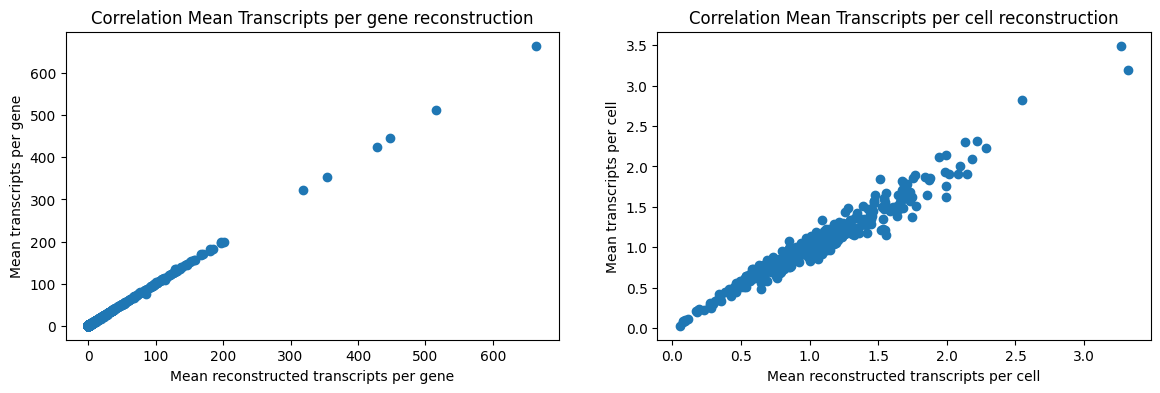

Correlation Coeff Gene Reconstruction: 0.9999169661479909 
Correlation Coeff Cell Reconstruction: 0.9769244920963317


In [526]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=1),
    (W @ H).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=0),
    (W @ H).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=1), (W @ H).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=0), (W @ H).mean(axis=0))[0, 1]}",
)

In [527]:
np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)

array([False, False, False, ..., False, False, False])

In [528]:
adata_sp_filtered

AnnData object with n_obs × n_vars = 997 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [529]:
list(adata_sp_filtered.var_names)[0:10]

['Acsl1',
 'Acta2',
 'Ada',
 'Adgrd1',
 'Adgrf5',
 'Adra1a',
 'Adra1b',
 'Adra2a',
 'Adra2b',
 'Adrb1']

In [530]:
H

array([[21.26177   , 28.685902  , 16.048315  , ...,  0.12589236,
         0.52733326,  0.        ],
       [ 1.7029655 ,  0.        , 13.322957  , ...,  2.7921085 ,
         1.428668  ,  0.9339231 ],
       [17.670872  , 10.896947  , 15.449143  , ...,  0.        ,
         0.        ,  0.08054108]], dtype=float32)

In [531]:
W[np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)]

array([[2.70333923e-02, 8.11414607e-03, 2.19436847e-02],
       [0.00000000e+00, 7.13246991e-04, 4.37571056e-04],
       [1.54552475e-01, 6.15506656e-02, 3.71021062e-01],
       [2.38371134e+00, 4.98333156e-01, 1.05160284e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.57848502e-03, 1.94394384e-02, 1.23391952e-02],
       [0.00000000e+00, 0.00000000e+00, 7.51169166e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.12632904e-03, 9.96426563e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.56026251e-04, 7.42329925e-04, 9.03962791e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.91159415e-04, 0.00000000e+00, 1.61068572e-04],
       [1.46871654e-03, 0.00000000e+00, 0.00000000e+00],
       [1.31738500e-03, 0.00000000e+00, 0.00000000e+00],
       [4.81556766e-02, 1.29598584e-02, 1.46526262e-01],
       [4.03857324e-04, 0.00000

**Taken from the sklearn NMF class description:**

Non-Negative Matrix Factorization (NMF).

Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H)
whose product approximates the non-negative matrix X. This factorization can be used
for example for dimensionality reduction, source separation or topic extraction.

The objective function is:
$$
L(W, H) = \frac{1}{2} \| X - WH \|_{\text{loss}}^2
+ \alpha_W \cdot l1\_ratio \cdot n_{\text{features}} \cdot \|\text{vec}(W)\|_1
+ \alpha_H \cdot l1\_ratio \cdot n_{\text{samples}} \cdot \|\text{vec}(H)\|_1
+ \frac{1}{2} \alpha_W \cdot (1 - l1\_ratio) \cdot n_{\text{features}} \cdot \|W\|_{Fro}^2
+ \frac{1}{2} \alpha_H \cdot (1 - l1\_ratio) \cdot n_{\text{samples}} \cdot \|H\|_{Fro}^2
$$

where $||A||_{Fro}^2 = \sum_{i,j} A_{ij}^2$ (Frobenius norm) and
$||vec(A)||_1 = \sum_{i,j} abs(A_{ij})$ (Elementwise L1 norm).

The generic norm $\| X - WH \|_{\text{loss}}$ may represent
the Frobenius norm or another supported beta-divergence loss.
The choice between options is controlled by the `beta_loss` parameter.

The regularization terms are scaled by `n_features` for `W` and by `n_samples` for
`H` to keep their impact balanced with respect to one another and to the data fit
term as independent as possible of the size `n_samples` of the training set.

The objective function is minimized with an alternating minimization of W
and H.

Note that the transformed data is named W and the components matrix is named H. In
the NMF literature, the naming convention is usually the opposite since the data
matrix X is transposed.


In [532]:
def validate_data(
    _estimator,
    /,
    X="no_validation",
    y="no_validation",
    reset=True,
    validate_separately=False,
    skip_check_array=False,
    **check_params,
):
    """Validate input data and set or check feature names and counts of the input.

    This helper function should be used in an estimator that requires input
    validation. This mutates the estimator and sets the `n_features_in_` and
    `feature_names_in_` attributes if `reset=True`.

    .. versionadded:: 1.6

    Parameters
    ----------
    _estimator : estimator instance
        The estimator to validate the input for.

    X : {array-like, sparse matrix, dataframe} of shape \
            (n_samples, n_features), default='no validation'
        The input samples.
        If `'no_validation'`, no validation is performed on `X`. This is
        useful for meta-estimator which can delegate input validation to
        their underlying estimator(s). In that case `y` must be passed and
        the only accepted `check_params` are `multi_output` and
        `y_numeric`.

    y : array-like of shape (n_samples,), default='no_validation'
        The targets.

        - If `None`, :func:`~sklearn.utils.check_array` is called on `X`. If
          the estimator's `requires_y` tag is True, then an error will be raised.
        - If `'no_validation'`, :func:`~sklearn.utils.check_array` is called
          on `X` and the estimator's `requires_y` tag is ignored. This is a default
          placeholder and is never meant to be explicitly set. In that case `X` must be
          passed.
        - Otherwise, only `y` with `_check_y` or both `X` and `y` are checked with
          either :func:`~sklearn.utils.check_array` or
          :func:`~sklearn.utils.check_X_y` depending on `validate_separately`.

    reset : bool, default=True
        Whether to reset the `n_features_in_` attribute.
        If False, the input will be checked for consistency with data
        provided when reset was last True.

        .. note::

           It is recommended to call `reset=True` in `fit` and in the first
           call to `partial_fit`. All other methods that validate `X`
           should set `reset=False`.

    validate_separately : False or tuple of dicts, default=False
        Only used if `y` is not `None`.
        If `False`, call :func:`~sklearn.utils.check_X_y`. Else, it must be a tuple of
        kwargs to be used for calling :func:`~sklearn.utils.check_array` on `X` and `y`
        respectively.

        `estimator=self` is automatically added to these dicts to generate
        more informative error message in case of invalid input data.

    skip_check_array : bool, default=False
        If `True`, `X` and `y` are unchanged and only `feature_names_in_` and
        `n_features_in_` are checked. Otherwise, :func:`~sklearn.utils.check_array`
        is called on `X` and `y`.

    **check_params : kwargs
        Parameters passed to :func:`~sklearn.utils.check_array` or
        :func:`~sklearn.utils.check_X_y`. Ignored if validate_separately
        is not False.

        `estimator=self` is automatically added to these params to generate
        more informative error message in case of invalid input data.

    Returns
    -------
    out : {ndarray, sparse matrix} or tuple of these
        The validated input. A tuple is returned if both `X` and `y` are
        validated.
    """
    _check_feature_names(_estimator, X, reset=reset)
    tags = get_tags(_estimator)
    if y is None and tags.target_tags.required:
        raise ValueError(
            f"This {_estimator.__class__.__name__} estimator "
            "requires y to be passed, but the target y is None."
        )

    no_val_X = isinstance(X, str) and X == "no_validation"
    no_val_y = y is None or isinstance(y, str) and y == "no_validation"

    if no_val_X and no_val_y:
        raise ValueError("Validation should be done on X, y or both.")

    default_check_params = {"estimator": _estimator}
    check_params = {**default_check_params, **check_params}

    if skip_check_array:
        if not no_val_X and no_val_y:
            out = X
        elif no_val_X and not no_val_y:
            out = y
        else:
            out = X, y
    elif not no_val_X and no_val_y:
        out = check_array(X, input_name="X", **check_params)
    elif no_val_X and not no_val_y:
        out = _check_y(y, **check_params)
    else:
        if validate_separately:
            # We need this because some estimators validate X and y
            # separately, and in general, separately calling check_array()
            # on X and y isn't equivalent to just calling check_X_y()
            # :(
            check_X_params, check_y_params = validate_separately
            if "estimator" not in check_X_params:
                check_X_params = {**default_check_params, **check_X_params}
            X = check_array(X, input_name="X", **check_X_params)
            if "estimator" not in check_y_params:
                check_y_params = {**default_check_params, **check_y_params}
            y = check_array(y, input_name="y", **check_y_params)
        else:
            X, y = check_X_y(X, y, **check_params)
        out = X, y

    if not no_val_X and check_params.get("ensure_2d", True):
        _check_n_features(_estimator, X, reset=reset)

    return out

def _fit_transform(self, X, y=None, W=None, H=None, update_H=True):
    """Learn a NMF model for the data X and returns the transformed data.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Data matrix to be decomposed

    y : Ignored

    W : array-like of shape (n_samples, n_components), default=None
        If `init='custom'`, it is used as initial guess for the solution.
        If `update_H=False`, it is initialised as an array of zeros, unless
        `solver='mu'`, then it is filled with values calculated by
        `np.sqrt(X.mean() / self._n_components)`.
        If `None`, uses the initialisation method specified in `init`.

    H : array-like of shape (n_components, n_features), default=None
        If `init='custom'`, it is used as initial guess for the solution.
        If `update_H=False`, it is used as a constant, to solve for W only.
        If `None`, uses the initialisation method specified in `init`.

    update_H : bool, default=True
        If True, both W and H will be estimated from initial guesses,
        this corresponds to a call to the 'fit_transform' method.
        If False, only W will be estimated, this corresponds to a call
        to the 'transform' method.

    Returns
    -------
    W : ndarray of shape (n_samples, n_components)
        Transformed data.

    H : ndarray of shape (n_components, n_features)
        Factorization matrix, sometimes called 'dictionary'.

    n_iter_ : int
        Actual number of iterations.
    """
    # check parameters
    self._check_params(X)

    if X.min() == 0 and self._beta_loss <= 0:
        raise ValueError(
            "When beta_loss <= 0 and X contains zeros, "
            "the solver may diverge. Please add small values "
            "to X, or use a positive beta_loss."
        )

    # initialize or check W and H
    W, H = self._check_w_h(X, W, H, update_H)

    # scale the regularization terms
    l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = self._compute_regularization(X)

    if self.solver == "cd":
        W, H, n_iter = _fit_coordinate_descent(
            X,
            W,
            H,
            self.tol,
            self.max_iter,
            l1_reg_W,
            l1_reg_H,
            l2_reg_W,
            l2_reg_H,
            update_H=update_H,
            verbose=self.verbose,
            shuffle=self.shuffle,
            random_state=self.random_state,
        )
    elif self.solver == "mu":
        W, H, n_iter, *_ = _fit_multiplicative_update(
            X,
            W,
            H,
            self._beta_loss,
            self.max_iter,
            self.tol,
            l1_reg_W,
            l1_reg_H,
            l2_reg_W,
            l2_reg_H,
            update_H,
            self.verbose,
        )
    else:
        raise ValueError("Invalid solver parameter '%s'." % self.solver)

    if n_iter == self.max_iter and self.tol > 0:
        warnings.warn(
            "Maximum number of iterations %d reached. Increase "
            "it to improve convergence." % self.max_iter,
            ConvergenceWarning,
        )

    return W, H, n_iter

def fit_transform(self, X, y=None, W=None, H=None):
    """Learn a NMF model for the data X and returns the transformed data.

    This is more efficient than calling fit followed by transform.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training vector, where `n_samples` is the number of samples
        and `n_features` is the number of features.

    y : Ignored
        Not used, present for API consistency by convention.

    W : array-like of shape (n_samples, n_components), default=None
        If `init='custom'`, it is used as initial guess for the solution.
        If `None`, uses the initialisation method specified in `init`.

    H : array-like of shape (n_components, n_features), default=None
        If `init='custom'`, it is used as initial guess for the solution.
        If `None`, uses the initialisation method specified in `init`.

    Returns
    -------
    W : ndarray of shape (n_samples, n_components)
        Transformed data.
    """
    X = validate_data(
        self, X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
    )

    with config_context(assume_finite=True):
        W, H, n_iter = self._fit_transform(X, W=W, H=H)

    self.reconstruction_err_ = _beta_divergence(
        X, W, H, self._beta_loss, square_root=True
    )

    self.n_components_ = H.shape[0]
    self.components_ = H
    self.n_iter_ = n_iter

    return W

In [533]:
from sklearn.decomposition._cdnmf_fast import _update_cdnmf_fast
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_array, check_random_state


def _update_coordinate_descent(X, W, Ht, l1_reg, l2_reg, shuffle, random_state):
    """Helper function for _fit_coordinate_descent.

    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).

    """
    n_components = Ht.shape[1]

    HHt = np.dot(Ht.T, Ht)
    XHt = safe_sparse_dot(X, Ht)

    # L2 regularization corresponds to increase of the diagonal of HHt
    if l2_reg != 0.0:
        # adds l2_reg only on the diagonal
        HHt.flat[:: n_components + 1] += l2_reg
    # L1 regularization corresponds to decrease of each element of XHt
    if l1_reg != 0.0:
        XHt -= l1_reg

    if shuffle:
        permutation = random_state.permutation(n_components)
    else:
        permutation = np.arange(n_components)
    # The following seems to be required on 64-bit Windows w/ Python 3.5.
    permutation = np.asarray(permutation, dtype=np.intp)
    return _update_cdnmf_fast(W, HHt, XHt, permutation)

def _fit_coordinate_descent(
    X,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
    shuffle=False,
    random_state=None,
):
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent

    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Constant matrix.

    W : array-like of shape (n_samples, n_components)
        Initial guess for the solution.

    H : array-like of shape (n_components, n_features)
        Initial guess for the solution.

    tol : float, default=1e-4
        Tolerance of the stopping condition.

    max_iter : int, default=200
        Maximum number of iterations before timing out.

    l1_reg_W : float, default=0.
        L1 regularization parameter for W.

    l1_reg_H : float, default=0.
        L1 regularization parameter for H.

    l2_reg_W : float, default=0.
        L2 regularization parameter for W.

    l2_reg_H : float, default=0.
        L2 regularization parameter for H.

    update_H : bool, default=True
        Set to True, both W and H will be estimated from initial guesses.
        Set to False, only W will be estimated.

    verbose : int, default=0
        The verbosity level.

    shuffle : bool, default=False
        If true, randomize the order of coordinates in the CD solver.

    random_state : int, RandomState instance or None, default=None
        Used to randomize the coordinates in the CD solver, when
        ``shuffle`` is set to ``True``. Pass an int for reproducible
        results across multiple function calls.
        See :term:`Glossary <random_state>`.

    Returns
    -------
    W : ndarray of shape (n_samples, n_components)
        Solution to the non-negative least squares problem.

    H : ndarray of shape (n_components, n_features)
        Solution to the non-negative least squares problem.

    n_iter : int
        The number of iterations done by the algorithm.

    References
    ----------
    .. [1] :doi:`"Fast local algorithms for large scale nonnegative matrix and tensor
       factorizations" <10.1587/transfun.E92.A.708>`
       Cichocki, Andrzej, and P. H. A. N. Anh-Huy. IEICE transactions on fundamentals
       of electronics, communications and computer sciences 92.3: 708-721, 2009.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")

    rng = check_random_state(random_state)

    for n_iter in range(1, max_iter + 1):
        violation = 0.0

        # Update W
        violation += _update_coordinate_descent(
            X, W, Ht, l1_reg_W, l2_reg_W, shuffle, rng
        )
        # Update H
        if update_H:
            violation += _update_coordinate_descent(
                X.T, Ht, W, l1_reg_H, l2_reg_H, shuffle, rng
            )

        if n_iter == 1:
            violation_init = violation

        if violation_init == 0:
            break

        if verbose:
            print("violation:", violation / violation_init)

        if violation / violation_init <= tol:
            if verbose:
                print("Converged at iteration", n_iter + 1)
            break

    return W, Ht.T, n_iter

In [611]:
from sklearn.decomposition._nmf import _check_init, _initialize_nmf, _beta_divergence
from sklearn.exceptions import ConvergenceWarning
from sklearn._config import config_context
from sklearn.utils.validation import validate_data

def _fit_coordinate_descent_adapted(
    X,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H = True,
):
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent

    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Constant matrix.

    W : array-like of shape (n_samples, n_components)
        Initial guess for the solution.

    H : array-like of shape (n_components, n_features)
        Initial guess for the solution.

    tol : float, default=1e-4
        Tolerance of the stopping condition.

    max_iter : int, default=200
        Maximum number of iterations before timing out.

    l1_reg_W : float, default=0.
        L1 regularization parameter for W.

    l1_reg_H : float, default=0.
        L1 regularization parameter for H.

    l2_reg_W : float, default=0.
        L2 regularization parameter for W.

    l2_reg_H : float, default=0.
        L2 regularization parameter for H.

    Returns
    -------
    W : ndarray of shape (n_samples, n_components)
        Solution to the non-negative least squares problem.

    H : ndarray of shape (n_components, n_features)
        Solution to the non-negative least squares problem.

    n_iter : int
        The number of iterations done by the algorithm.

    References
    ----------
    .. [1] :doi:`"Fast local algorithms for large scale nonnegative matrix and tensor
       factorizations" <10.1587/transfun.E92.A.708>`
       Cichocki, Andrzej, and P. H. A. N. Anh-Huy. IEICE transactions on fundamentals
       of electronics, communications and computer sciences 92.3: 708-721, 2009.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")

    _update_coordinate_descent = lambda X, W, Ht, l1_reg, l2_reg: _update_cdnmf_fast(
        W,
        np.dot(Ht.T, Ht) + (np.eye(Ht.shape[1], dtype=X.dtype) * (l2_reg)), 
        safe_sparse_dot(X, Ht) - l1_reg,
        np.arange(Ht.shape[1])
    )

    for n_iter in range(1, max_iter + 1):
        violation = 0.0
        # Update W
        violation += _update_coordinate_descent(X, W, Ht, l1_reg_W, l2_reg_W)
        # Update H
        if update_H:
            violation += _update_coordinate_descent(X.T, Ht, W, l1_reg_H, l2_reg_H)

        if n_iter == 1:
            violation_init = violation
        if violation_init == 0:
            break
        if violation / violation_init <= tol:
            break
    return W, Ht.T, n_iter


def _check_w_h(X, n_components, W, H, init=None, update_H=True):
    """Check W and H, or initialize them."""
    n_samples, n_features = X.shape

    if init == "custom" and update_H:
        _check_init(H, (n_components, X.shape[0]), "NMF (input H)")
        _check_init(W, (X.shape[1], n_components), "NMF (input W)")

        if H.dtype != X.dtype or W.dtype != X.dtype:
            raise TypeError(
                "H and W should have the same dtype as X. Got "
                "H.dtype = {} and W.dtype = {}.".format(H.dtype, W.dtype)
            )

    elif not update_H:
        if W is not None:
            warnings.warn(
                "When update_H=False, the provided initial W is not used.",
                RuntimeWarning,
            )

        _check_init(H, (n_components, X.shape[0]), "NMF (input H)")

        if H.dtype != X.dtype:
            raise TypeError(
                "H should have the same dtype as X. Got H.dtype = {}.".format(
                    H.dtype
                )
            )

        W = np.zeros((X.shape[1], n_components), dtype=X.dtype)

    else:
        if W is not None or H is not None:
            warnings.warn(
                (
                    "When init!='custom', provided W or H are ignored. Set "
                    " init='custom' to use them as initialization."
                ),
                RuntimeWarning,
            )

        W, H = _initialize_nmf(
            X, n_components, init=init
        )

    return W, H

def _fit_transform_adapted(X, n_components, y=None, W=None, H=None, update_H=True, alpha_W=0.0, alpha_H=0.0, l1_ratio=0.0, tol=1e-4, max_iter=200):
        """Learn a NMF model for the data X and returns the transformed data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Data matrix to be decomposed

        y : Ignored

        W : array-like of shape (n_samples, n_components), default=None
            If `init='custom'`, it is used as initial guess for the solution.
            If `update_H=False`, it is initialised as an array of zeros, unless
            `solver='mu'`, then it is filled with values calculated by
            `np.sqrt(X.mean() / self._n_components)`.
            If `None`, uses the initialisation method specified in `init`.

        H : array-like of shape (n_components, n_features), default=None
            If `init='custom'`, it is used as initial guess for the solution.
            If `update_H=False`, it is used as a constant, to solve for W only.
            If `None`, uses the initialisation method specified in `init`.

        update_H : bool, default=True
            If True, both W and H will be estimated from initial guesses,
            this corresponds to a call to the 'fit_transform' method.
            If False, only W will be estimated, this corresponds to a call
            to the 'transform' method.

        Returns
        -------
        W : ndarray of shape (n_samples, n_components)
            Transformed data.

        H : ndarray of shape (n_components, n_features)
            Factorization matrix, sometimes called 'dictionary'.

        n_iter_ : int
            Actual number of iterations.
        """
        # check parameters
        #self._check_params(X)

        #if X.min() == 0 and self._beta_loss <= 0:
        #    raise ValueError(
        #        "When beta_loss <= 0 and X contains zeros, "
        #        "the solver may diverge. Please add small values "
        #        "to X, or use a positive beta_loss."
        #    )

        # initialize or check W and H
        W, H = _check_w_h(X=X, n_components=n_components, W=W, H=H, update_H=update_H)

        W, H, n_iter = _fit_coordinate_descent_adapted(
            X,
            W,
            H,
            l1_reg_W=X.shape[0] * alpha_W * l1_ratio,
            l1_reg_H=X.shape[1] * alpha_H * l1_ratio,
            l2_reg_W=X.shape[0] * alpha_W * (1.0 - l1_ratio),
            l2_reg_H=X.shape[1] * alpha_H * (1.0 - l1_ratio),
            
        )
        if n_iter == max_iter and tol > 0:
            warnings.warn(
                "Maximum number of iterations %d reached. Increase "
                "it to improve convergence." % max_iter,
                ConvergenceWarning,
            )

        return W, H, n_iter

def fit_transform_adapted(self, X, y=None, W=None, H=None):
    """Learn a NMF model for the data X and returns the transformed data.

    This is more efficient than calling fit followed by transform.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Data matrix to be decomposed.

    y : Ignored
        Not used, present here for API consistency by convention.

    W : array-like of shape (n_samples, n_components), default=None
        If `init='custom'`, it is used as initial guess for the solution.
        If `None`, uses the initialisation method specified in `init`.

    H : array-like of shape (n_components, n_features), default=None
        If `init='custom'`, it is used as initial guess for the solution.
        If `None`, uses the initialisation method specified in `init`.

    Returns
    -------
    W : ndarray of shape (n_samples, n_components)
        Transformed data.
    """
    X = validate_data(
        self, X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
    )

    with config_context(assume_finite=True):
        W, H, n_iter = self._fit_transform(X, W=W, H=H)

    self.reconstruction_err_ = _beta_divergence(
        X, W, H, self._beta_loss, square_root=True
    )

    self.n_components_ = H.shape[0]
    self.components_ = H
    self.n_iter_ = n_iter
    self.n_steps_ = n_steps

    return W

In [627]:
X = adata_sc_filtered.X.toarray().copy().T
with config_context(assume_finite=True):
    W, H, n_iter = _fit_transform_adapted(X, n_components=3, W=None, H=None)

reconstruction_err_ = _beta_divergence(X, W, H, "frobenius", square_root=True)

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_34618/794263601.py:210: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [628]:
W, H

(array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00167003],
        ...,
        [0.19643058, 0.10931563, 0.15880486],
        [0.02652682, 0.01224245, 0.        ],
        [0.00043111, 0.        , 0.        ]], dtype=float32),
 array([[21.261667  , 28.685764  , 16.048237  , ...,  0.12589557,
          0.52733314,  0.        ],
        [ 1.7029433 ,  0.        , 13.322961  , ...,  2.7921147 ,
          1.4286717 ,  0.9339252 ],
        [17.6709    , 10.896975  , 15.449171  , ...,  0.        ,
          0.        ,  0.0805415 ]], dtype=float32))

In [630]:
W, H

(array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00167004],
        ...,
        [0.19643056, 0.10931512, 0.15880479],
        [0.02652677, 0.01224239, 0.        ],
        [0.00043111, 0.        , 0.        ]], dtype=float32),
 array([[21.261713  , 28.685808  , 16.048265  , ...,  0.12589265,
          0.5273322 ,  0.        ],
        [ 1.7029498 ,  0.        , 13.32305   , ...,  2.792133  ,
          1.428681  ,  0.93393147],
        [17.670853  , 10.896946  , 15.449126  , ...,  0.        ,
          0.        ,  0.08054069]], dtype=float32))

In [602]:
[_fit_transform_adapted(X, n_components=3) for _ in range(2)]

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_34618/214351816.py:208: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_34618/214351816.py:208: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[(array([[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.00167003],
         ...,
         [0.19643053, 0.10931594, 0.15880477],
         [0.02652678, 0.01224257, 0.        ],
         [0.00043111, 0.        , 0.        ]], dtype=float32),
  array([[21.261686  , 28.685787  , 16.048216  , ...,  0.1258882 ,
           0.52732944,  0.        ],
         [ 1.7029173 ,  0.        , 13.322964  , ...,  2.7921197 ,
           1.4286746 ,  0.9339265 ],
         [17.670895  , 10.896966  , 15.449174  , ...,  0.        ,
           0.        ,  0.08054032]], dtype=float32),
  200),
 (array([[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.00167003],
         ...,
         [0.19643115, 0.10931528, 0.1588049 ],
         [0.02652684, 0.0122425 , 0.        ],
         [0.00043111, 0.        , 0.        ]], dtype=float32),
  array([[21.261633  , 28.685694  , 1

In [585]:
debug_list

[[array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [2., 4., 4., ..., 0., 2., 2.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([[9.8857951e-01, 9.8857951e-01, 3.6710804e-05],
         [9.8857951e-01, 9.8857951e-01, 9.8857951e-01],
         [8.0575468e-04, 9.8857951e-01, 1.0782577e-03],
         ...,
         [2.7763841e-01, 9.8857951e-01, 9.8857951e-01],
         [2.1468336e-02, 3.5585135e-03, 9.8857951e-01],
         [3.0268269e-04, 9.8857951e-01, 9.8857951e-01]], dtype=float32),
  array([[25.083084  ,  0.9885795 ,  5.303331  ],
         [24.439966  ,  0.9885795 ,  0.9885795 ],
         [25.938011  ,  2.1075618 ,  4.419909  ],
         ...,
         [ 1.2632922 ,  3.3489437 ,  0.9885795 ],
         [ 0.91882634,  1.4685208 ,  0.9885795 ],
         [ 0.48426846,  1.0938467 ,  0.9885795 ]], dtype=float32),
  np.float32(0.0),
  np.float32

In [581]:
debug_list[0]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [2., 4., 4., ..., 0., 2., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[9.8857951e-01, 9.8857951e-01, 2.2940740e-05],
        [9.8857951e-01, 9.8857951e-01, 9.8857951e-01],
        [8.0575305e-04, 9.8857951e-01, 1.0779443e-03],
        ...,
        [2.7763829e-01, 9.8857951e-01, 9.8857951e-01],
        [2.1468358e-02, 3.5585370e-03, 9.8857951e-01],
        [3.0268391e-04, 9.8857951e-01, 9.8857951e-01]], dtype=float32),
 array([[25.08308   ,  0.9885795 ,  5.3033495 ],
        [24.439976  ,  0.9885795 ,  0.9885795 ],
        [25.93801   ,  2.107556  ,  4.419828  ],
        ...,
        [ 1.2632911 ,  3.3489435 ,  0.9885795 ],
        [ 0.9188258 ,  1.4685209 ,  0.9885795 ],
        [ 0.48426804,  1.0938466 ,  0.9885795 ]], dtype=float32),
 array(0., dtype=float32),
 array(0., dtype=float32)

In [594]:
np.dot(debug_list[0][2].T, debug_list[0][2]) + (np.eye(debug_list[0][2].shape[1], dtype=X.dtype) * (debug_list[0][3]))

array([[36964.82  , 10906.439 ,  8052.587 ],
       [10906.439 ,  9264.844 ,  1788.9309],
       [ 8052.587 ,  1788.9309,  3311.558 ]], dtype=float32)

In [596]:
(lambda X, W, Ht, l1_reg, l2_reg: _update_cdnmf_fast(
        W,
        np.dot(Ht.T, Ht) + (np.eye(Ht.shape[1], dtype=X.dtype) * (l2_reg)), 
        safe_sparse_dot(X, Ht) - l1_reg,
        np.arange(Ht.shape[1])
))(*debug_list[0])

1486182400.0

In [574]:
np.array(debug_list[0][3], dtype=X.dtype)

array(0., dtype=float32)

In [499]:
X.shape

(32287, 420)

In [501]:
W.shape

(32287, 3)

In [503]:
_check_init(W_test, (32287, 3), "NMF (input W)")

In [480]:
X.shape

(32287, 420)

In [491]:
n_features = 3
l1_ratio = 1
alpha_W, alpha_H = .0, .0

X = adata_sc_filtered.X.transpose().toarray()
# Random Initialization
#np.random.seed(5)
#W_test = np.random.rand(X.shape[0], n_features)
#H_test = np.random.rand(n_features, X.shape[1])

# Zero Initialization
W_test = np.zeros((X.shape[0], n_features), dtype=X.dtype)
H_test = np.zeros((n_features, X.shape[1]), dtype=X.dtype)

res = _fit_coordinate_descent_adapted(
    H=H_test,
    W=W_test,
    X=X,
    l1_reg_W=n_features * alpha_W * l1_ratio,
    l1_reg_H=X.shape[0] * alpha_H * l1_ratio,
    l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio),
    l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio),
)
res

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 1)

In [493]:
n_features = 3
l1_ratio = 1
alpha_W, alpha_H = .0, .0

X = adata_sc_filtered.X.transpose().toarray()
# Random Initialization
#np.random.seed(5)
#W_test = np.random.rand(X.shape[0], n_features)
#H_test = np.random.rand(n_features, X.shape[1])

# Zero Initialization
W_test = np.zeros((X.shape[0], n_features))
H_test = np.zeros((n_features, X.shape[1]))

res = _fit_coordinate_descent(
    H=H_test,
    W=W_test,
    X=X,
    l1_reg_W=n_features * alpha_W * l1_ratio,
    l1_reg_H=X.shape[0] * alpha_H * l1_ratio,
    l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio),
    l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio),
)
res

(array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00670514, 0.        , 0.        ],
        ...,
        [1.03360301, 0.16003099, 0.89829819],
        [0.        , 0.01592251, 0.20910314],
        [0.        , 0.        , 0.00295093]]),
 array([[4.40749309e+00, 3.27873411e+00, 3.72970031e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.47572751e-02],
        [8.69931023e-01, 8.10721029e-02, 8.41087220e+00, ...,
         1.80535193e+00, 9.43763952e-01, 6.04756138e-01],
        [2.73102473e+00, 4.43934856e+00, 2.04803208e+00, ...,
         6.28516073e-02, 1.27556841e-01, 5.09966941e-04]]),
 200)

In [468]:
np.random.seed(5)
W_test = np.random.rand(32287, 3)
H_test = np.random.rand(3, 420)

n_features = 3
l1_ratio = 1
alpha_W, alpha_H = .0, .0
l1_reg_W=n_features * alpha_W * l1_ratio
l1_reg_H=X.shape[0] * alpha_H * l1_ratio
l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio)
l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio)

res_1 = _fit_coordinate_descent(
    H=H_test,
    W=W_test,
    X=X,
    l1_reg_W=n_features * alpha_W * l1_ratio,
    l1_reg_H=X.shape[0] * alpha_H * l1_ratio,
    l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio),
    l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio),
)
res_1

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.12134902e-02, 0.00000000e+00],
        ...,
        [1.23747636e+00, 1.66484609e+00, 4.34888790e-01],
        [9.77194467e-02, 0.00000000e+00, 1.02905669e-01],
        [0.00000000e+00, 0.00000000e+00, 1.42673224e-03]]),
 array([[2.50794171e-01, 1.13877640e-01, 1.20218785e+00, ...,
         2.32794130e-01, 1.21681156e-01, 7.84692362e-02],
        [2.63839322e+00, 1.95778369e+00, 2.23158341e+00, ...,
         0.00000000e+00, 0.00000000e+00, 8.73112686e-03],
        [5.62332239e+00, 9.17455796e+00, 4.22571500e+00, ...,
         1.31427082e-01, 2.64625003e-01, 1.88919010e-03]]),
 200)

In [125]:
np.dot(check_array(H.T, order="C").T, check_array(H.T, order="C")).shape

(3, 3)

In [104]:
H_test.shape

(3, 420)

In [107]:
safe_sparse_dot(X, H_test.T) - 0.0

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
HHt = np.dot(Ht.T, Ht) + (np.eye(Ht.shape[1] * l2_reg))
XHt = safe_sparse_dot()

In [64]:
X = adata_sc_filtered.X.transpose().toarray()
W_test = np.zeros((32287, 3))
H_test = np.zeros((3, 420))
X, W_test, H_test

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [2., 4., 4., ..., 0., 2., 2.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [454]:
n_features = 3
l1_ratio = 1
alpha_W, alpha_H = .0, .0
l1_reg_W=n_features * alpha_W * l1_ratio
l1_reg_H=X.shape[0] * alpha_H * l1_ratio
l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio)
l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio)
_fit_coordinate_descent(
    H=H_test,
    W=W_test,
    X=X,
    l1_reg_W=n_features * alpha_W * l1_ratio,
    l1_reg_H=X.shape[0] * alpha_H * l1_ratio,
    l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio),
    l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio),
)

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.14763626e-01, 0.00000000e+00],
        ...,
        [1.05172578e+00, 3.17494217e+01, 3.43425634e-01],
        [8.37193560e-02, 0.00000000e+00, 8.06338547e-02],
        [0.00000000e+00, 0.00000000e+00, 1.12038758e-03]]),
 array([[2.94432811e-01, 1.33568374e-01, 1.41474997e+00, ...,
         2.74152036e-01, 1.43274033e-01, 9.23890961e-02],
        [1.37761121e-01, 1.01959255e-01, 1.16598232e-01, ...,
         0.00000000e+00, 0.00000000e+00, 4.60673946e-04],
        [7.17796067e+00, 1.16830165e+01, 5.39002509e+00, ...,
         1.64802320e-01, 3.34578405e-01, 1.96651386e-03]]),
 200)

In [ ]:
n_features = 3
l1_ratio = 1
alpha_W, alpha_H = .0, .0
l1_reg_W=n_features * alpha_W * l1_ratio
l1_reg_H=X.shape[0] * alpha_H * l1_ratio
l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio)
l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio)

res = _fit_coordinate_descent_adapted(
    H=H_test,
    W=W_test,
    X=X,
    l1_reg_W=n_features * alpha_W * l1_ratio,
    l1_reg_H=X.shape[0] * alpha_H * l1_ratio,
    l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio),
    l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio),
)

In [456]:
np.random.seed(5)
W_test = np.random.rand(32287, 3)
Ht = check_array(np.random.rand(3, 420).T, order="C")
W_test, Ht

(array([[0.22199317, 0.87073231, 0.20671916],
        [0.91861091, 0.48841119, 0.61174386],
        [0.76590786, 0.51841799, 0.2968005 ],
        ...,
        [0.94330607, 0.72970754, 0.07879227],
        [0.09241553, 0.81545633, 0.37343554],
        [0.93611557, 0.77928695, 0.08012056]]),
 array([[0.6190048 , 0.85795757, 0.27449357],
        [0.32434028, 0.52767169, 0.63938031],
        [0.76901345, 0.60164408, 0.39331134],
        ...,
        [0.97972754, 0.81449403, 0.00673139],
        [0.72633687, 0.41517378, 0.31265285],
        [0.11414151, 0.60414174, 0.00418503]]))

In [457]:
res = _fit_coordinate_descent_adapted(
    H=H_test,
    W=W_test,
    X=X,
    l1_reg_W=n_features * alpha_W * l1_ratio,
    l1_reg_H=X.shape[0] * alpha_H * l1_ratio,
    l2_reg_W=n_features * alpha_W * (1.0 - l1_ratio),
    l2_reg_H=X.shape[0] * alpha_H * (1.0 - l1_ratio),
)

(array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00691173, 0.        , 0.        ],
        ...,
        [1.06545479, 0.1568212 , 0.63792704],
        [0.        , 0.01559818, 0.14851166],
        [0.        , 0.        , 0.00209567]]),
 array([[4.27587694e+00, 3.18071171e+00, 3.61827487e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.43117337e-02],
        [8.88588131e-01, 8.33902105e-02, 8.58384305e+00, ...,
         1.84230702e+00, 9.63080405e-01, 6.17145117e-01],
        [3.84522093e+00, 6.25116295e+00, 2.88358966e+00, ...,
         8.85047024e-02, 1.79625411e-01, 7.22665016e-04]]),
 200)

In [442]:
(lambda X, W, Ht, l1_reg, l2_reg: _update_cdnmf_fast(
    W,
    np.dot(Ht.T, Ht) + (np.eye(Ht.shape[1]) * (l2_reg)), 
    safe_sparse_dot(X, Ht) - l1_reg,
    np.arange(Ht.shape[1])
))(X, W_test, Ht, l1_reg_W, l2_reg_W)

16184809.129557373

In [450]:
(lambda X, W, Ht, l1_reg, l2_reg: _update_cdnmf_fast(
    W,
    np.dot(Ht.T, Ht) + (np.eye(Ht.shape[1]) * (l2_reg)), 
    safe_sparse_dot(X, Ht) - l1_reg,
    np.arange(Ht.shape[1])
))(X.T, Ht, W_test, l1_reg_H, l2_reg_H)

4390737.6297253715

In [452]:
_update_coordinate_descent(
            X, W_test, Ht, l1_reg_W, l2_reg_W, False, check_random_state(None)
        )


Ht shape (420, 3)
HHt shape (3, 3)


16184809.129557373

In [448]:
_update_coordinate_descent(
                X.T, Ht, W_test, l1_reg_H, l2_reg_H, False, check_random_state(None)
            )

Ht shape (32287, 3)
HHt shape (3, 3)


4390737.6297253715